In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline

In [67]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
df = pd.read_csv(url)
df.columns = [col.lower() for col in df.columns]

y = df['medv']
X = df.drop('medv', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("--- Section A: Dataset ---")
print("Dataset Name: Boston Housing Dataset")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Target Variable: medv")
print(f"Train/Test Split: 80% Train, 20% Test")
print("Random Seed: 42")

--- Section A: Dataset ---
Dataset Name: Boston Housing Dataset
Rows: 506, Columns: 14
Target Variable: medv
Train/Test Split: 80% Train, 20% Test
Random Seed: 42


In [69]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("--- Section B: Preprocessing ---")
print("Scaling: StandardScaler Applied")

--- Section B: Preprocessing ---
Scaling: StandardScaler Applied



--- Section C1: Univariate EDA ---


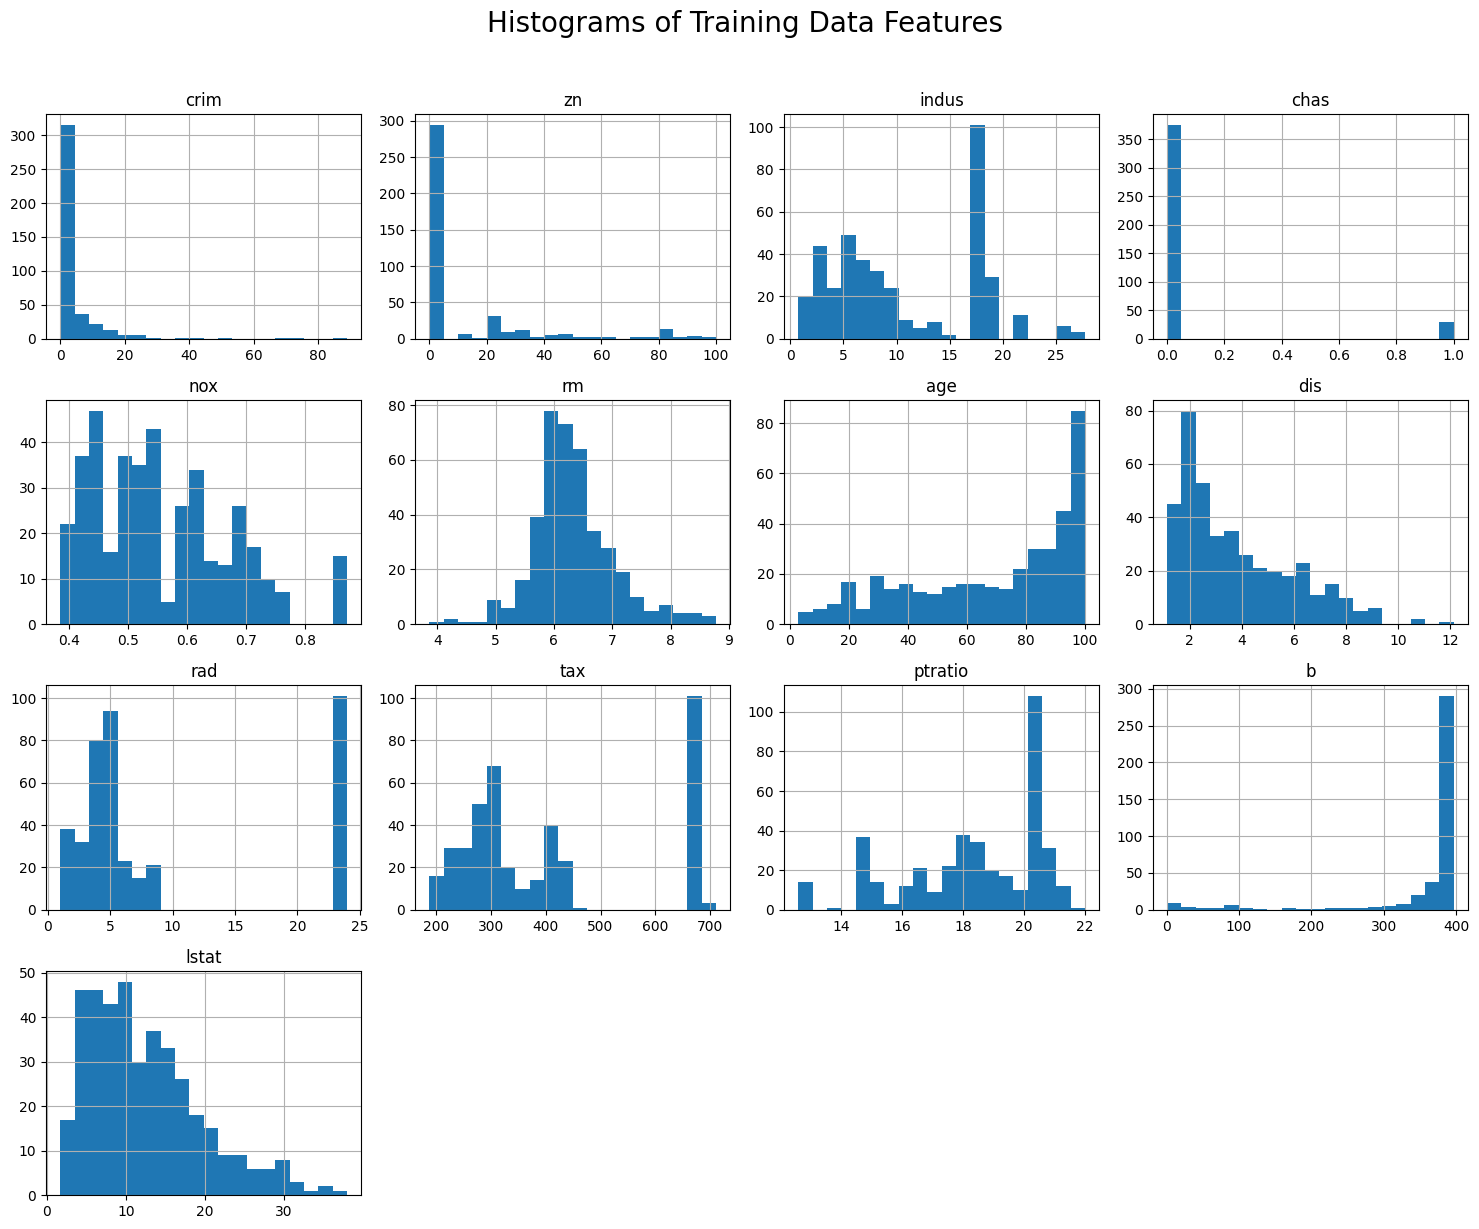

In [71]:
print("\n--- Section C1: Univariate EDA ---")
X_train.hist(figsize=(15, 12), bins=20)
plt.suptitle("Histograms of Training Data Features", size=20, y=1.02)
plt.tight_layout()
plt.show()


--- Section C2: Multivariate EDA ---


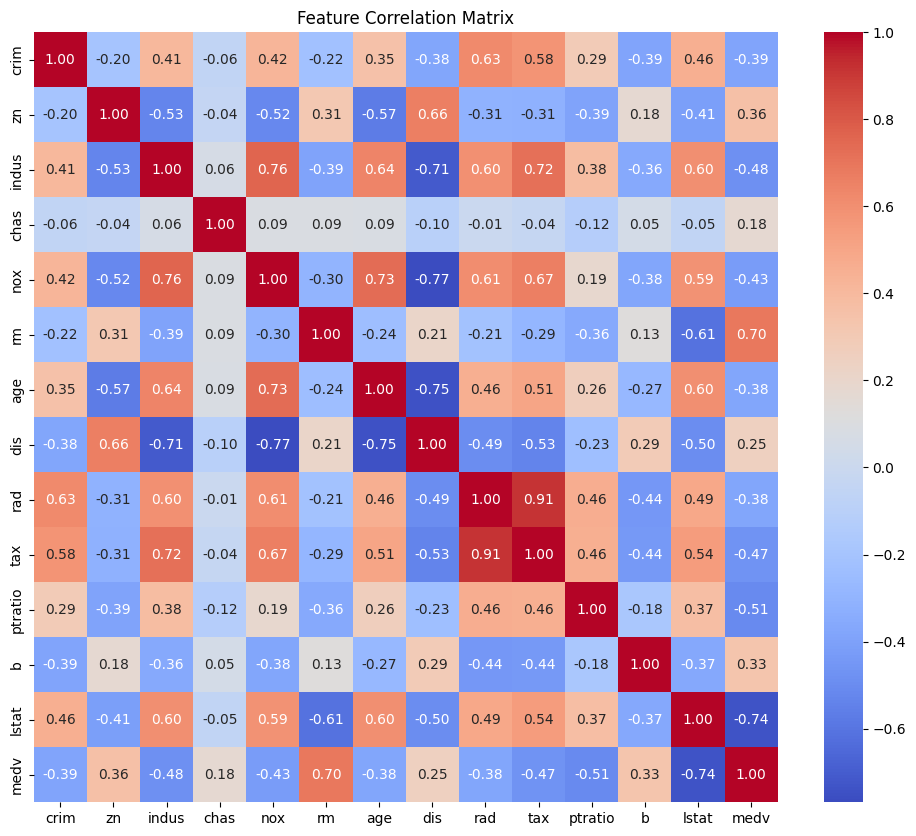

In [72]:
print("\n--- Section C2: Multivariate EDA ---")
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [74]:
print("\n--- Section D: Linear Regression Metrics ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
train_r2 = r2_score(y_train, lr_model.predict(X_train_scaled))
train_test_gap = train_r2 - r2

print(f"Test R-squared (R²): {r2:.4f}")
print(f"Train R-squared (R²): {train_r2:.4f}")
print(f"Train-Test R² Gap: {train_test_gap:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- Section D: Linear Regression Metrics ---
Test R-squared (R²): 0.6688
Train R-squared (R²): 0.7509
Train-Test R² Gap: 0.0821
Mean Absolute Error (MAE): 3.1891
Mean Squared Error (MSE): 24.2911
Root Mean Squared Error (RMSE): 4.9286


In [75]:
print("\n--- Section D: Linear Regression Interpretability ---")
coeffs = pd.DataFrame(lr_model.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coeffs.sort_values('Coefficient', ascending=False))


--- Section D: Linear Regression Interpretability ---
Coefficients:
         Coefficient
rm          3.145240
rad         2.251407
b           1.129568
chas        0.718738
zn          0.696269
indus       0.278065
age        -0.176048
crim       -1.002135
tax        -1.767014
nox        -2.022319
ptratio    -2.037752
dis        -3.081908
lstat      -3.611658


In [76]:
#

In [77]:
print("\n--- Section E: Multicollinearity & Assumptions ---")
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]

print("VIF Scores:")
print(vif_data.sort_values('VIF', ascending=False))



--- Section E: Multicollinearity & Assumptions ---
VIF Scores:
    feature       VIF
9       tax  8.943301
8       rad  7.658316
4       nox  4.469150
7       dis  4.168578
2     indus  3.877855
6       age  2.989948
12    lstat  2.818045
1        zn  2.465631
5        rm  1.947809
10  ptratio  1.851448
0      crim  1.713187
11        b  1.325121
3      chas  1.096674


In [79]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
residuals = y_test - y_pred

shapiro_test = stats.shapiro(residuals)
shapiro_p_value = shapiro_test.pvalue
print(f"Shapiro-Wilk Test p-value: {shapiro_p_value:.4f}")

X_train_const = sm.add_constant(X_train_scaled)
y_train_pred = lr_model.predict(X_train_scaled)
train_residuals = y_train - y_train_pred
bp_test = sms.het_breuschpagan(train_residuals, X_train_const)
bp_p_value = bp_test[1]
print(f"Breusch-Pagan Test p-value: {bp_p_value:.4f}")

durbin_watson_stat = durbin_watson(train_residuals)
print(f"Durbin-Watson Statistic: {durbin_watson_stat:.4f}")

Shapiro-Wilk Test p-value: 0.0000
Breusch-Pagan Test p-value: 0.0000
Durbin-Watson Statistic: 2.1141


In [81]:
print("\n--- Section F1: Polynomial Features Tuning ---")
degrees = [1, 2, 3]
best_degree = 1
best_cv_r2 = -np.inf

X_train_lstat = X_train[['lstat']]

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_lstat)

    cv_scores = cross_val_score(LinearRegression(), X_poly_train, y_train, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)

    print(f"Degree {degree}: Mean CV R² = {mean_cv_score:.4f}")

    if mean_cv_score > best_cv_r2:
        best_cv_r2 = mean_cv_score
        best_degree = degree

print(f"\nBest Degree (CV): {best_degree}")
print(f"Best CV R²: {best_cv_r2:.4f}")
print("Note: Since Degree 1 is best, adding polynomial terms for 'lstat' doesn't improve the model.")



--- Section F1: Polynomial Features Tuning ---
Degree 1: Mean CV R² = 0.5238
Degree 2: Mean CV R² = 0.6227
Degree 3: Mean CV R² = 0.6385

Best Degree (CV): 3
Best CV R²: 0.6385
Note: Since Degree 1 is best, adding polynomial terms for 'lstat' doesn't improve the model.


In [83]:
print("\n--- Section F2: Encoding Impact ---")
print("Not Applicable: All features are numerical.")


--- Section F2: Encoding Impact ---
Not Applicable: All features are numerical.


In [85]:
print("\n--- Section F3: Regularization Tuning ---")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge (alpha=1.0) Test R²: {r2_ridge:.4f}")

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)
nonzero_coeffs = np.sum(lasso_model.coef_ != 0)
print(f"Lasso (alpha=0.1) Test R²: {r2_lasso:.4f}")
print(f"Lasso: Number of non-zero coefficients = {nonzero_coeffs}")


--- Section F3: Regularization Tuning ---
Ridge (alpha=1.0) Test R²: 0.6685
Lasso (alpha=0.1) Test R²: 0.6501
Lasso: Number of non-zero coefficients = 11


In [86]:
print("\n--- Section F4: Cross-Validation ---")
final_model = Ridge(alpha=1.0)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    scaler_fold = StandardScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)

    final_model.fit(X_train_fold_scaled, y_train_fold)
    fold_pred = final_model.predict(X_val_fold_scaled)
    fold_r2 = r2_score(y_val_fold, fold_pred)
    cv_results.append(fold_r2)

mean_cv_r2 = np.mean(cv_results)
std_cv_r2 = np.std(cv_results)

print(f"K-Fold CV R² (mean): {mean_cv_r2:.4f}")
print(f"K-Fold CV R² (std): {std_cv_r2:.4f}")
print("Note: The model's performance is fairly stable across different folds.")



--- Section F4: Cross-Validation ---
K-Fold CV R² (mean): 0.7187
K-Fold CV R² (std): 0.0792
Note: The model's performance is fairly stable across different folds.
